In [ ]:
import numpy as np
import json
from pprint import pprint
import math
import scipy
from scipy import linalg
import sklearn
from sklearn import linear_model
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel

In [ ]:
np.random.seed(0)

amount_of_points = 10
dist = 1.5
X = np.random.normal(loc=[dist,dist], scale=[0.5,1.0], 
        size=[amount_of_points,2])
Y = np.zeros(X.shape[0])

X = np.vstack([X, np.random.normal(loc=[-dist, -dist], 
    scale=[0.5, 1], size=[amount_of_points,2])])
Y = np.hstack([Y, np.ones(amount_of_points)]).astype(np.int32)


In [ ]:
def get_min_max(X, h):
    # get the minimum and maximum in x and y direction
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    return x_min, x_max, y_min, y_max

def create_mesh(X, h):
    # create a mesh to plot in
    x_min, x_max, y_min, y_max = get_min_max(X, h)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

# Plot also the training points
def plot_points(X, Y, h):
    plt.scatter(X[:, 0], X[:, 1], c=np.array(["r", "b"])[Y],
                edgecolors=(0, 0, 0))
    xx, yy = create_mesh(X, h)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    # remove axis information
    plt.xticks(())
    plt.yticks(())

Final kernel: 18.7**2 * RBF(length_scale=3.66)


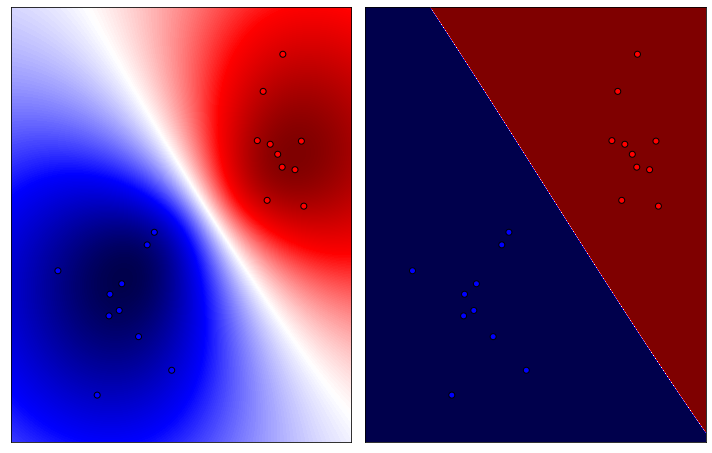

In [ ]:
kernel = 1 * RBF([1.0])
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel).fit(X, Y)
print("Final kernel: {}".format(gpc_rbf_isotropic.kernel_))

plt.figure(figsize=(10, 10))
h = 0.005
xx, yy = create_mesh(X, h)

# predict the probabilities for each value
Z = gpc_rbf_isotropic.predict_proba(np.c_[xx.ravel(), yy.ravel()])


# Plot the predicted probabilities. For that, we will assign a color to
# each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 2, 1)
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1], 2))[:, :, 0]
plt.imshow(Z, extent=(xx.min(), xx.max(), yy.min(), yy.max()), origin="lower", cmap="seismic")
plot_points(X, Y, h)
  
plt.subplot(1, 2, 2)
plt.imshow(np.round(Z), extent=(xx.min(), xx.max(), yy.min(), yy.max()), origin="lower", cmap="seismic")
plot_points(X, Y, h)

plt.tight_layout()
plt.show()

# From the book: Gaussian Processes for Machine Learning by Carl Edward Rasmussen
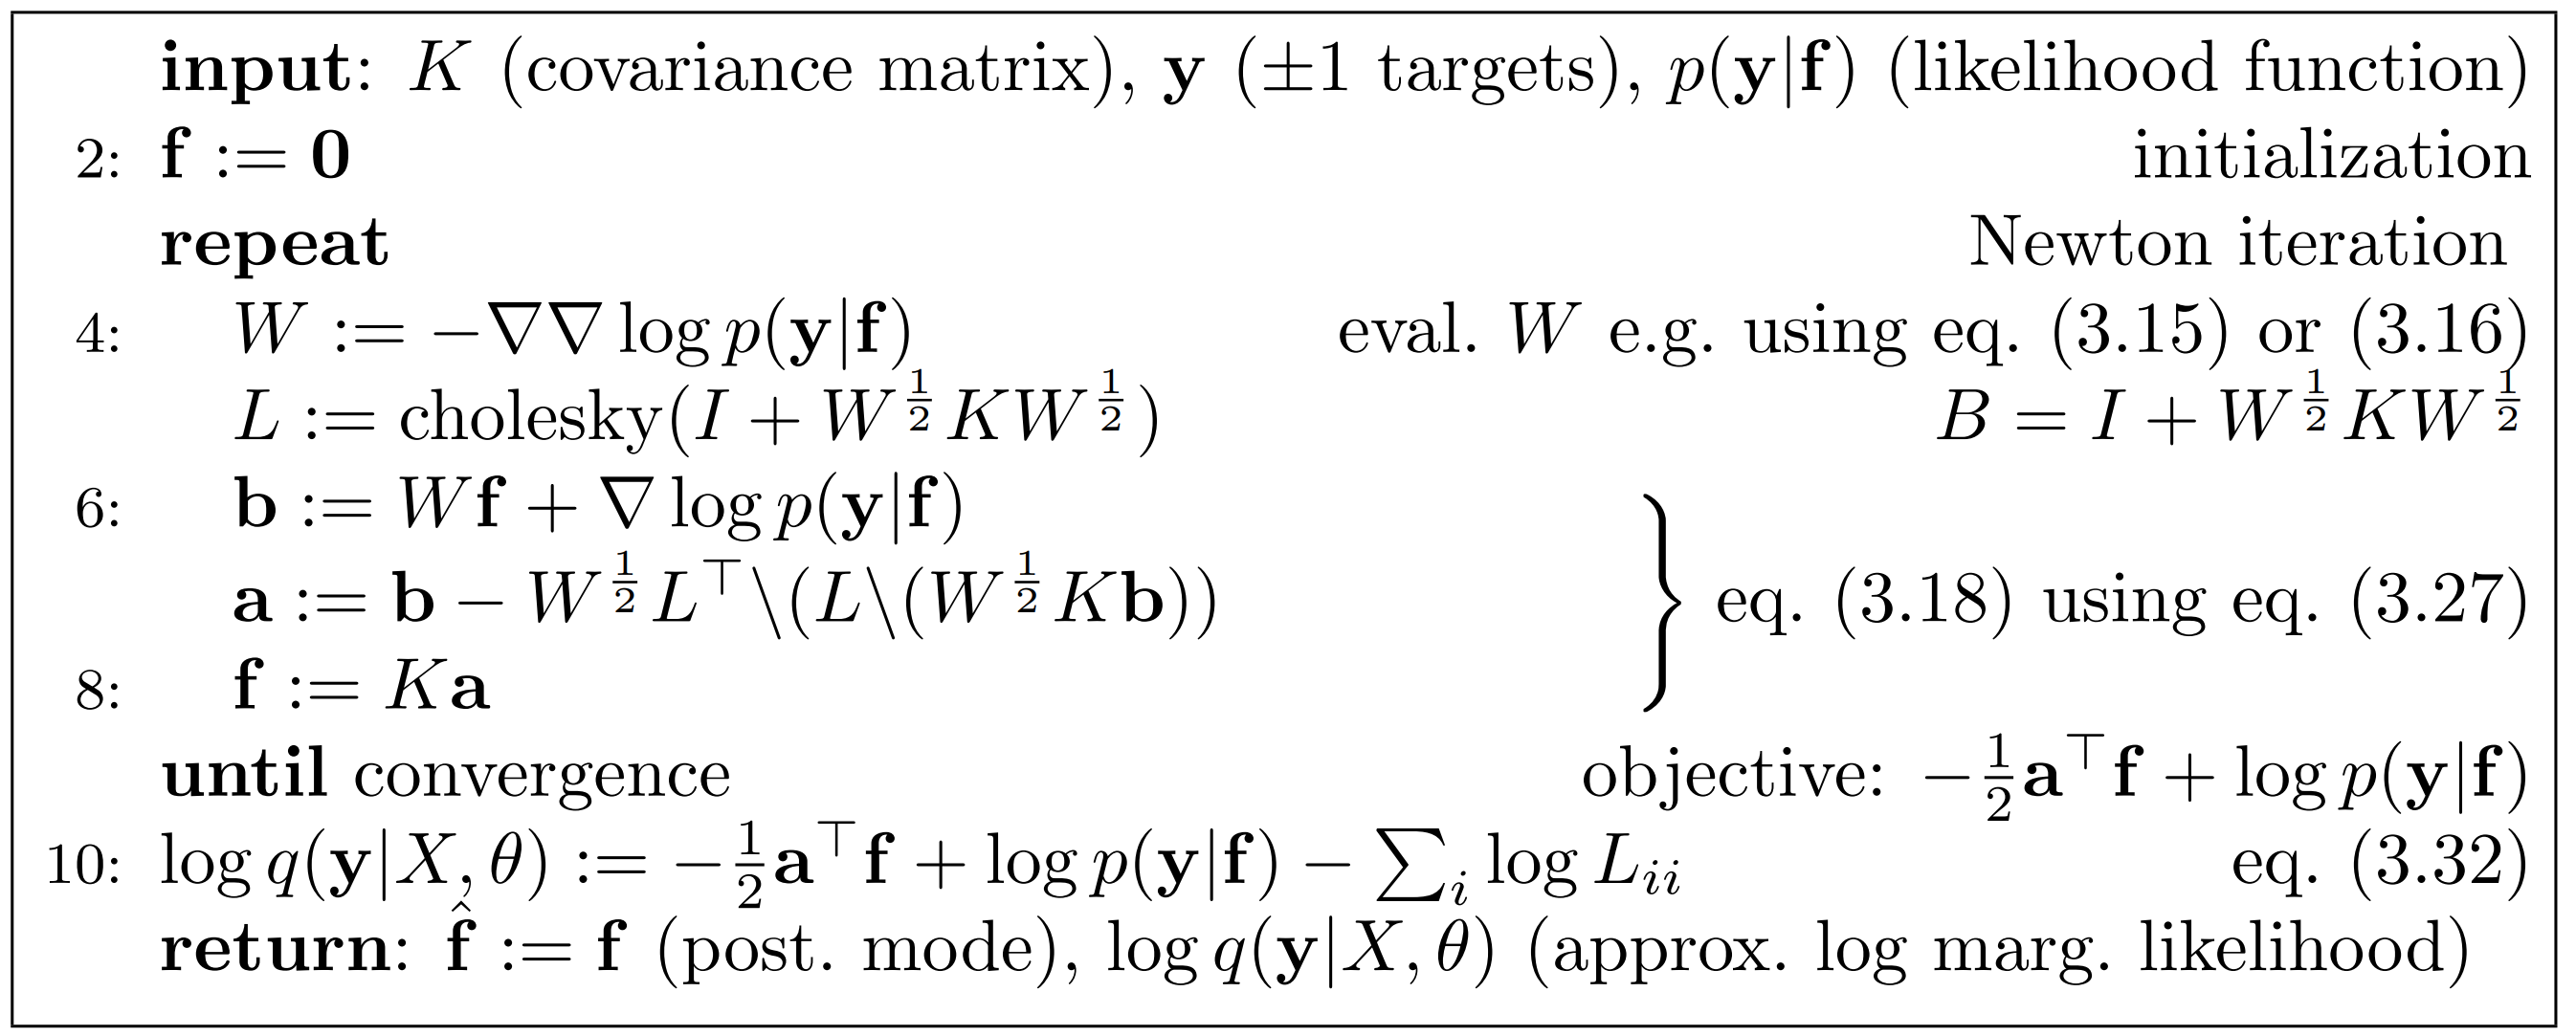

Here, $K$ is our kernel matrix, similar to the GP regression case. $W$ corresponds to the Hessian Matrix of the negative log posterior at that point $f$. 

For the optimization we have to define the following things, our final goal is to update $f$ via: 

$f = (K^{-1} + W)^{-1} (Wf + ∇log(p(y|f)))$

However, $(K^{-1} + W)^{-1}$ is numerically unstable, so we first define the last part as $b$:

$b = Wf + ∇log(p(y|f))$

And then use the matrix inversion lemma to reform it: 

$f = (K^{-1} + W)^{-1}  b$

$f = (K - K  W^{\frac{1}{2}}  (I + W^{\frac{1}{2}}  K  W^{\frac{1}{2}})  W^{\frac{1}{2}}  K)  b$

The inner part of this: 
$(I + W^{\frac{1}{2}}  K  W^{\frac{1}{2}}) $
is still numerically unstable but we can use the Cholesky decomposition here:

$f = (K - K  W^{\frac{1}{2}}  L.T^{-1}  L^{-1}  W^{\frac{1}{2}}  K) b$

$f = (Kb - K  W^{\frac{1}{2}}  L.T^{-1}  L^{-1}  W^{\frac{1}{2}}  Kb)$, move the $b$ inside

$f = K (b - W^{\frac{1}{2}}  L.T^{-1}  L^{-1}  W^{\frac{1}{2}}  Kb)$, pull the $K$ out

And finally we can define the part in parenthesis as $a$:

$a = b - W^{\frac{1}{2}}  L.T^{-1}  L^{-1}  W^{\frac{1}{2}} K$

Giving us: 

$f = K a$

In [ ]:
def rbf_kernel(i, j, length, sig):
    """
    Calculates for two elements i and j, with the given hyperparams length and sig the rbf kernel result
    """
    diff = np.linalg.norm(i - j)
    return sig * np.exp((-diff * diff) / length)

def create_K(x, length, sig):
    n = len(x)
    K = np.array([rbf_kernel(i, j, length, sig) for i in x for j in x]).reshape(n, n)
    return K

def numerically_stable_cdf(i):
    """
    Converts the input i from -infinity to infinity to 0 to 1.
    """
    cdf_value = norm.cdf(i)
    if cdf_value == 0:
        return 1e-16
    elif cdf_value == 1:
        return 1 - 1e-16
    else:
        return cdf_value

def loglik_deriv_i(y_i, f_i):
    """
    Calculate the first element wise derivative of the log likelihood
    """
    return y_i * norm.pdf(f_i) / numerically_stable_cdf(y_i * f_i)

def loglik_deriv_2_i(y_i, f_i):
    """
    Calculate the second element wise derivative of the log likelihood
    """
    pdf_div_cdf = norm.pdf(f_i) / numerically_stable_cdf(y_i * f_i)
    return -pdf_div_cdf * pdf_div_cdf - y_i * f_i * pdf_div_cdf

def loglik_deriv(Y, f):
    """, step_size)
    print("Done training")
    h = 0.2
    xx, yy = create_mesh(X, h)
    x_min, x_max, y_min, y_max = get_min_max(X, h)
    C_classes = np.zeros(xx.shape)
    for i in range(len(xx)):
        for j in range(len(xx[0])):
    Calculate for all $f$ the first derivative of the log likelihood
    """
    deriv = np.array([loglik_deriv_i(y_i, f_i) for y_i, f_i in zip(Y, f)])
    return deriv

def create_W_vec(Y, f):
    """
    Calculate the hessian matrix, via the second derivative of the negative log likelihood
    This fct. only returns the diagonal of it, the rest is zero, as it factorizes over cases, meaning that the
    distribution for $y_i$ only depends on $f_i$.
    """
    W = np.array([loglik_deriv_2_i(y_i, f_i) for y_i, f_i in zip(Y, f)])
    return W * -1

def create_W(Y, f):
    """
    Calculate $W$ the hessian matrix, via the second derivative of the negative log likelihood
    """
    return np.diag(create_W_vec(Y, f))

def create_K_star(X, x_new, length, sig):
    """
    Returns the K_star for a newly given point x_new, which is compared to all existing points X,
    by using the rbf_kernel.
    """
    K_star = np.array([rbf_kernel(x_new, i, length, sig) for i in X]).reshape((1, X.shape[0]))
    return K_star

def optimize_f_cholesky(X, Y, K, step_size=1):
    """
    Optimize $f$ with the cholesky decomposition. This makes it numerically more stable.
    """
    n = len(X)
    f_new = np.zeros(n)  # initialize with zero
    L, W_sqrt = None, None
    for epoch in range(1000):
        f = f_new
        # calculate the second derivative for the current point $f$
        W = create_W_vec(Y, f)
        W_sqrt = np.diag(np.sqrt(np.abs(W)))  # Absolute values to work around 0 -- values should never be negative
        # where $b = W * f + ∇log(p(y|f))$
        b = np.dot(W, f) + step_size * loglik_deriv(Y, f)
        # calculate the cholesky decomposition of:
        # $I + sqrt(W) * K * sqrt(W)$
        L = np.linalg.cholesky(np.eye(n) + np.dot(np.dot(W_sqrt, K), W_sqrt))
        # where $f = inv(inv(K) + W) * b$, however this is numerically unstable:
        # so:   $f = (K - K * sqrt(W) * (I + sqrt(W) * K * sqrt(W)) * sqrt(W) * K) * b$, with the matrix inversion lemma
        # so:   $f = (K - K * sqrt(W) * inv(L.T) * inv(L) * sqrt(W) * K) * b$, with the matrix inversion lemma
        # so:   $f = Kb - K * sqrt(W) * inv(L.T) * inv(L) * sqrt(W) * K * b$, with the matrix inversion lemma
        # so:   $f = K * (b - sqrt(W) * inv(L.T) * inv(L) * sqrt(W) * K)$, with the matrix inversion lemma
        # so:   $f = K * a$
        # where $a = (b - sqrt(W) * inv(L.T) * inv(L) * sqrt(W) * K)$
        a = b - np.dot(W_sqrt, np.dot(np.linalg.inv(L.T), np.dot(np.linalg.inv(L), np.dot(W_sqrt, np.dot(K, b)))))
        f_new = np.dot(K, a)
        # if the change between the last point and the current point is smaller than 1e-5, stop the optimizing
        if np.linalg.norm(f - f_new) < 1e-5:
            print("Done after {} steps with optimizing.".format(epoch))
            break
    return f_new, np.abs(W_sqrt), L


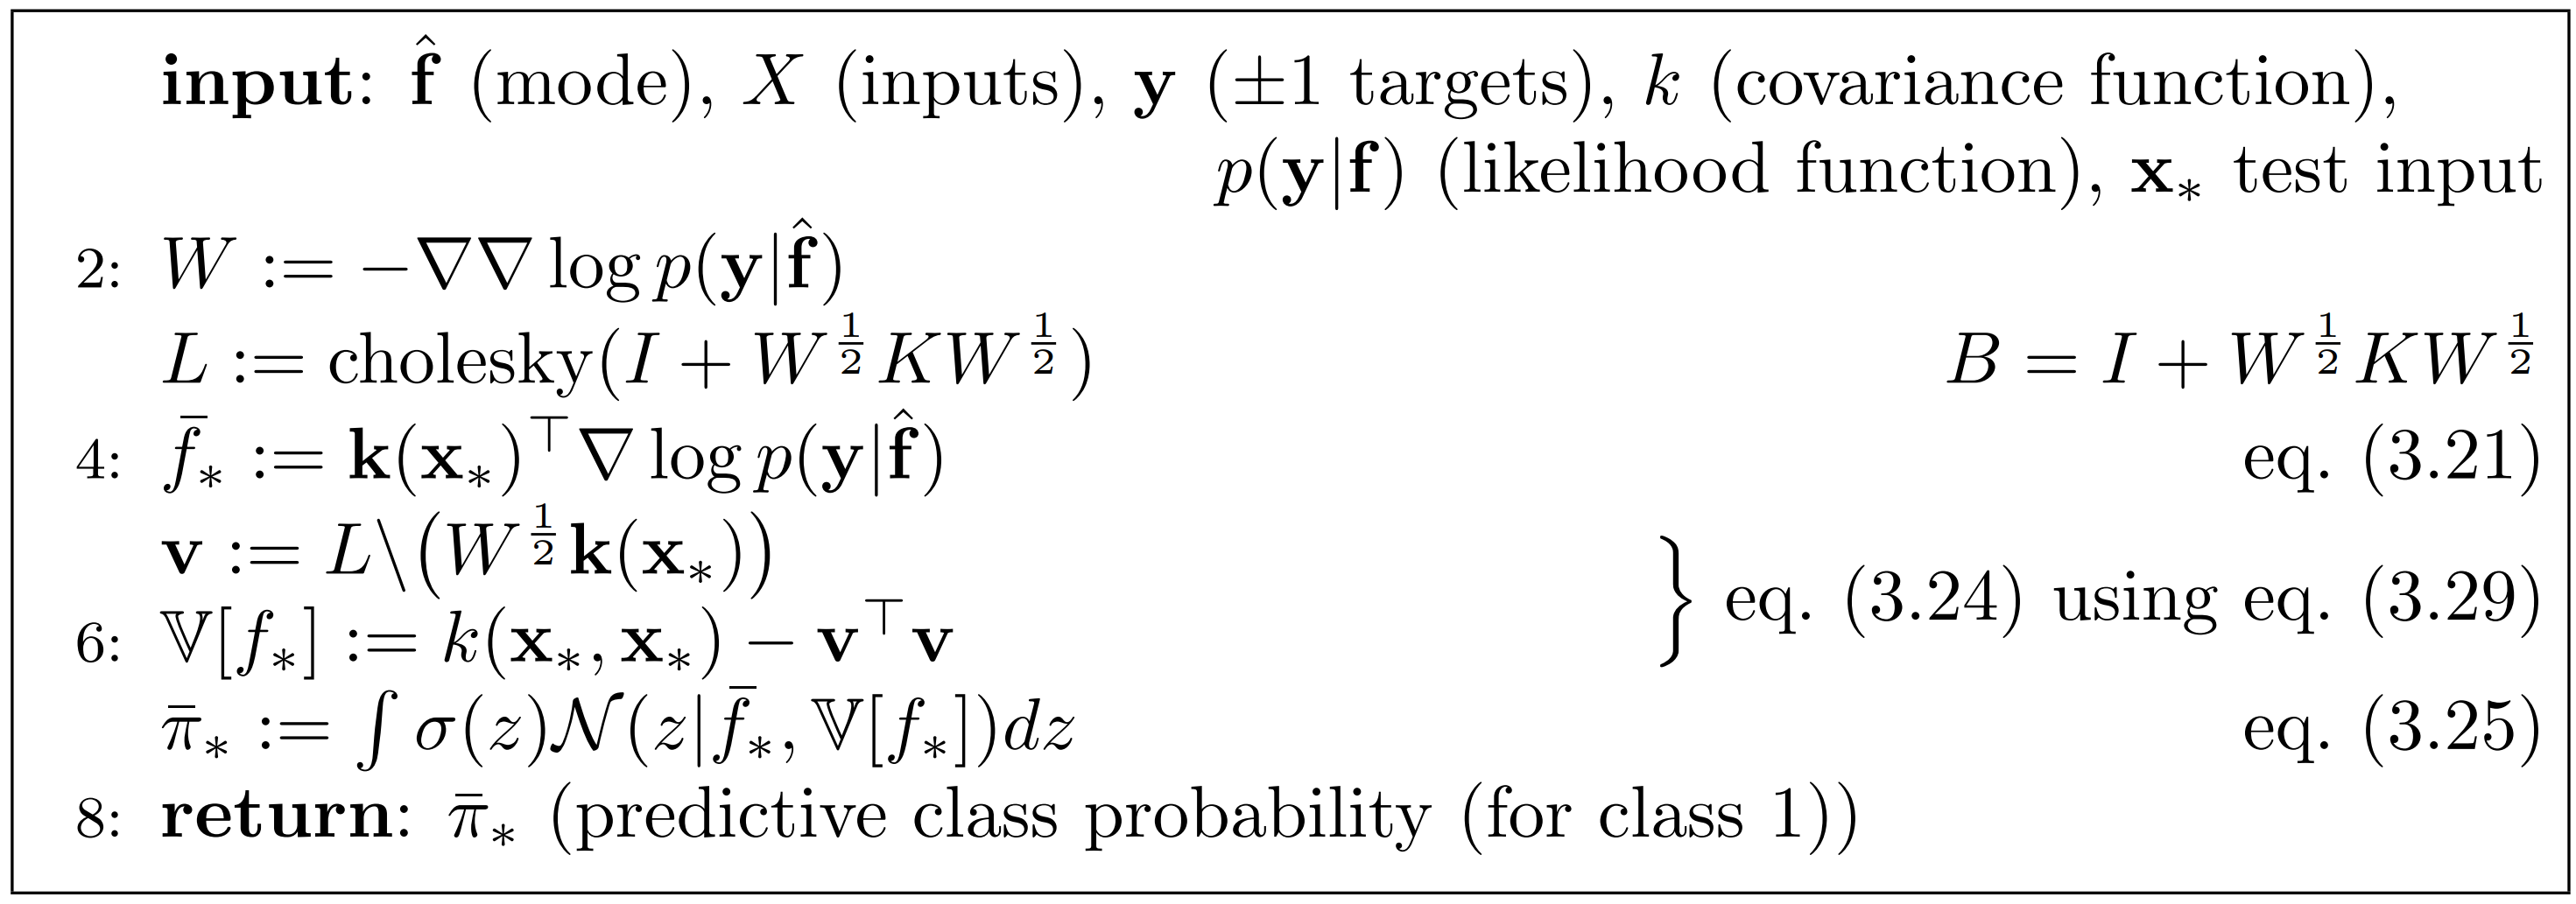

Here, $W$ and $L$ are used from the training and don't have to be recalculated.

4: $\bar {f_*} = k(x_*)^T K^{-1} \hat f = k(x_*)^T  ∇log(p(y|f))$

for 6:

$V[f_*] = k(x_*, x_*) - k_*^T (K + W^{-1})^{-1}  k_*$

Here $k(x_*, x_*)$ is the self similarity for the new data point. And $k_*$ is the similarity of the new point with all existing data points.

Replacing as before this: 

$V[f_*] = k(x_*, x_*) - k_*^T (K + W^{-1})^{-1}  k_*$

$V[f_*] = k(x_*, x_*) - k_*^T W^{\frac{1}{2}}  (L L.T)^{-1}  W^{\frac{1}{2}}  * k_*$

And now we can split the last term:

$v = \frac{L}{(W^{\frac{1}{2}} k_*)}$

In the end we only have to caluclate for the choosen mapping function the integral over all values till $f_*$.


Done training


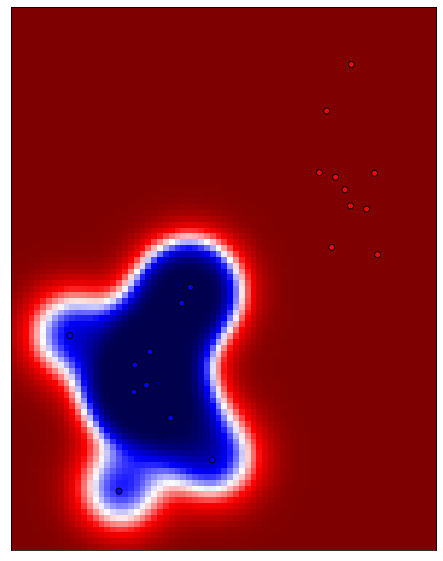

In [ ]:
def predict_and_error_cholesky(X, Y, x_new, f_hat, W_sqrt, L, length, sig):
    """
    Predicts for a single point x_new an output probability
    """
    # The similarity with all existing data points
    K_star = create_K_star(X, x_new, length, sig)
    # The similarity with itself 
    K_star_star = rbf_kernel(x_new, x_new, length, sig)
    f_star = np.dot(K_star, loglik_deriv(Y, f_hat))
    v = np.dot(np.linalg.inv(L), np.dot(W_sqrt, K_star.T))
    # numerically it is better to clip this value shortly above -1
    V = np.clip(K_star_star - np.dot(v.T, v), -1. + 1e-6, 100000.0)
    pi_star = numerically_stable_cdf(f_star / (np.sqrt(1 + V)))
    return pi_star


def plot_preds_cholesky_2d(X, Y, length, sig, h, step_size=1):
    """
    Constructs a GP and predicts an image like output
    :param h: the resolution of the final image
    """
    plt.figure(figsize=(10, 10))
    # This model assumes the classes to be -1 and 1
    corrected_Y = np.array([1 if e == 1 else -1 for e in Y])
    K = create_K(X, length, sig)
    f_hat, W_sqrt, L = optimize_f_cholesky(X, corrected_Y, K, step_size)
    print("Done training")
    xx, yy = create_mesh(X, h)
    x_min, x_max, y_min, y_max = get_min_max(X, h)
    C_classes = np.zeros(xx.shape)
    for i in range(len(xx)):
        for j in range(len(xx[0])):
            xi = xx[i][j]
            xj = yy[i][j]
            C_classes[i][j] = 1 - np.clip(
                predict_and_error_cholesky(X, corrected_Y, np.array([xi, xj]), 
                                           f_hat, W_sqrt, L, length, sig), 0, 1)

    plt.imshow(C_classes, extent=(x_min, x_max, y_min, y_max), origin="lower", cmap="seismic")
    plot_points(X, Y, h)
    plt.show()


plot_preds_cholesky_2d(X, Y, 0.5, 0.1, h=0.1, step_size=0.1)

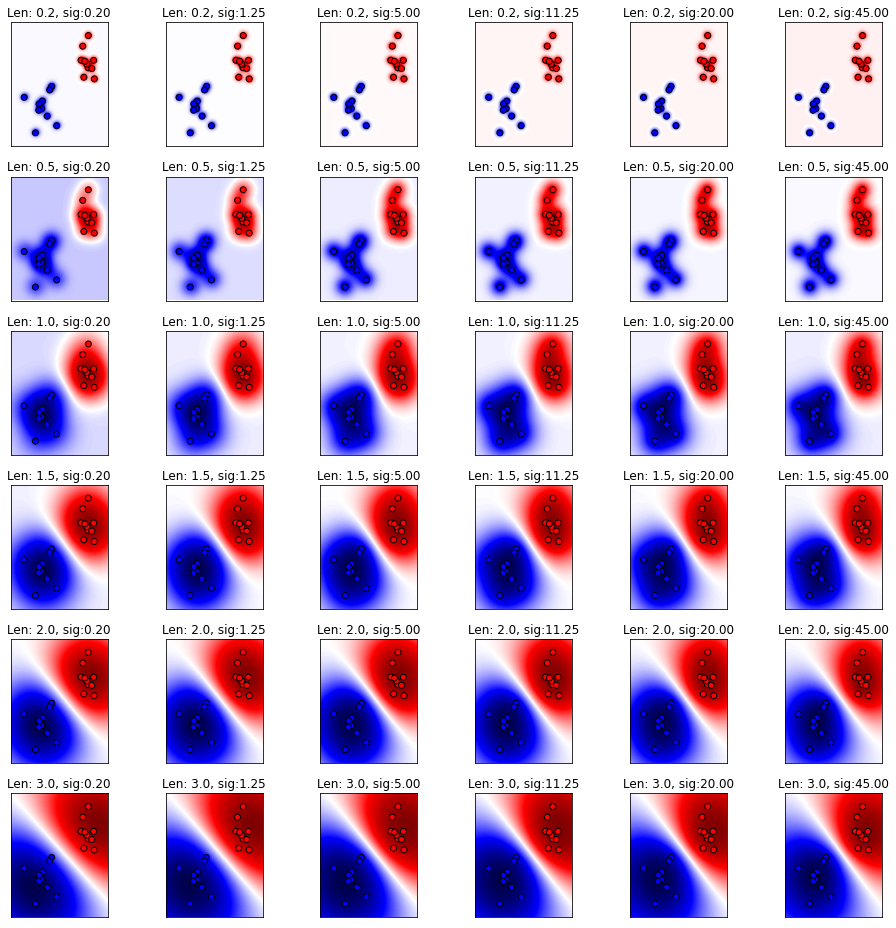

In [ ]:
# plot for different hyperparams the output
hyperparams = [0.2, 0.5, 1.0, 1.5, 2.0, 3.0]

plt.figure(figsize=(13, 13))
h = 0.05
xx, yy = create_mesh(X, h)
for i, length in enumerate(hyperparams):
    for j, sigma in enumerate(hyperparams):
        sigma *= sigma 
        sigma *= 5
        kernel = sigma * RBF([length])
        gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel, optimizer=None).fit(X, Y)
        
        # predict the probabilities for each value
        Z = gpc_rbf_isotropic.predict_proba(np.c_[xx.ravel(), yy.ravel()])

        # Plot the predicted probabilities. For that, we will assign a color to
        # each point in the mesh [x_min, m_max]x[y_min, y_max].
        plt.subplot(len(hyperparams), len(hyperparams), i * len(hyperparams) + j + 1)

        plt.title("Len: {}, sig:{:.2f}".format(length, sigma))
        # Put the result into a color plot
        Z = Z.reshape((xx.shape[0], xx.shape[1], 2))[:, :, 0]
        plt.imshow(Z, extent=(xx.min(), xx.max(), yy.min(), yy.max()), origin="lower", cmap="seismic")
        plot_points(X, Y, h)
          

plt.tight_layout()
plt.show()